<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Text2Image_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Text2Image v.3.0</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [CLIP](https://github.com/openai/CLIP), [BigGAN](https://github.com/ajbrock/BigGAN-PyTorch), [CMA-ES](https://github.com/CyberAgent/cmaes)

Article: [Learning Transferable Visual Models From Natural Language Supervision](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)

Creator: **[OpenAI](https://openai.com/)**

Colab based on **[Eyal Gruss's](http://eyalgruss.com/)** [notebook](https://colab.research.google.com/github/eyaler/clip_biggan/blob/main/WanderCLIP.ipynb).

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>

!nvidia-smi -L

try: 
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
except: pass

import subprocess
import cv2
import matplotlib.pyplot as plt
import os

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

!pip install pytorch-pretrained-biggan
from pytorch_pretrained_biggan import BigGAN
last_gen_model = 'biggan-deep-512'
biggan_model = BigGAN.from_pretrained(last_gen_model).cuda().eval()

%cd /content
!git clone --depth 1 https://github.com/openai/CLIP
!pip install ftfy
%cd /content/CLIP
import clip
last_clip_model = 'ViT-B/32'
perceptor, preprocess = clip.load(last_clip_model)

import nltk
nltk.download('wordnet')

!pip install cma

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Start Processing</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Начать обработку</font></b>

text = 'Photo of a forest fire' #@param {type:'string'}
#@markdown ---
#@markdown Advanced settings (Расширенные настройки)
try: prompt = translator.translate(text).text
except: prompt = text
gen_model = 'biggan-deep' #@param ['biggan-deep', 'sigmoid']
size = '512' #@param [512, 256, 128] 
color = True #@param {type:'boolean'}
initial_class = 'Random mix' #@param ['From prompt', 'Random class', 'Random Dirichlet', 'Random mix'] {allow-input: true}
optimize_class = True #@param {type:'boolean'}
class_smoothing = 0.1 #@param {type:'number'}
truncation = 1 #@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
optimizer = 'CMA-ES' #@param ['SGD','Adam','CMA-ES','CMA-ES+SGD','CMA-ES+Adam']
pop_size = 50 #@param {type:'integer'}
clip_model = 'ViT-B/32' #@param ['ViT-B/32','RN50']
augmentations =  64#@param {type:'integer'}
learning_rate =  0.1#@param {type:'number'}
regularization = 0.0001 #@param {type:'number'}
iterations = 100 #@param {type:'integer'}
save_every = 1 #@param {type:'integer'}
fps = 1 #@param {type:'number'}
freeze_secs = 0 #@param {type:'number'}
seed =  0#@param {type:'number'}
if seed == 0:
  seed = None
noise_size = 128
class_size = 1000
channels = 3 if color else 1
clip_res = perceptor.input_resolution.item()
gen_model = gen_model + '-' + size
if 'sigmoid' in gen_model:
  optimize_class = False
sideX = sideY = int(size)
if sideX<=clip_res and sideY<=clip_res:
  augmentations = 1
if 'CMA' not in optimizer:
  pop_size = 1
if gen_model != last_gen_model and 'biggan' in gen_model:
  biggan_model = BigGAN.from_pretrained(gen_model).cuda().eval()
  last_gen_model = gen_model
if clip_model != last_clip_model:
  perceptor, preprocess = clip.load(clip_model)
  last_clip_model = clip_model

!rm -rf /content/output
!mkdir -p /content/output

import numpy as np
state = None if not seed else np.random.RandomState(seed)
np.random.seed(seed)
import torch
import torchvision
import sys
torch.manual_seed(np.random.randint(sys.maxsize))
import imageio
from IPython.display import HTML, Image, clear_output
from scipy.stats import truncnorm, dirichlet
from pytorch_pretrained_biggan import convert_to_images, one_hot_from_names, utils
from nltk.corpus import wordnet as wn
from base64 import b64encode
from time import time
import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA
import warnings
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

def save(out,name):
  with torch.no_grad():
    out = out.cpu().numpy()
  if 'sigmoid' in gen_model:
    out = out*2 - 1
  img = convert_to_images(out)[0]
  imageio.imwrite(name, np.asarray(img))

def checkin(i, best_ind, total_losses, losses, regs, out, probs=None):
  global sample_num
  name = '/content/output/frame_%05d.jpg'%sample_num
  save(out, name)
  clear_output()
  display(Image(name))  
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%(sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs))
  if probs is not None:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%(ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size)
  print(stats)
  sample_num += 1

eps = 1e-8
if 'sigmoid' in gen_model:
  noise_size = channels*sideY*sideX
  noise_vector = np.random.rand(pop_size, noise_size).astype(np.float32)
  noise_vector = np.log((noise_vector+eps)/(1-noise_vector+eps))
else:
  noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(pop_size, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214

  if initial_class.lower() == 'random class':
    class_vector = np.ones(shape=(pop_size, class_size), dtype=np.float32)*class_smoothing/999
    class_vector[0,np.random.randint(class_size)] = 1-class_smoothing
  elif initial_class.lower() == 'random dirichlet':
    class_vector = dirichlet.rvs([pop_size/class_size] * class_size, size=1, random_state=state).astype(np.float32)
  elif initial_class.lower() == 'random mix':
    class_vector = np.random.rand(pop_size, class_size).astype(np.float32)
  else:
    if initial_class.lower() == 'from prompt':
      initial_class = prompt
    try:
      class_vector = one_hot_from_names([prompt], batch_size=pop_size)
      class_vector = class_vector*(1-class_smoothing*class_size/(class_size-1))+class_smoothing/(class_size-1)
    except Exception as e:  
      print('Error: could not find initial_class. Try something else.')
      raise e

  class_vector = class_vector/np.sum(class_vector,axis=-1, keepdims=True)
  class_vector = np.log(class_vector+eps)
  initial_class_vector = class_vector[0]
  if initial_class.lower() == 'random mix':
    initial_class_vector = initial_class_vector*0-np.log(class_size)
  class_vector = torch.tensor(class_vector, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')
  smoothed_ent = -torch.tensor(class_smoothing*np.log(class_smoothing/999+eps)+(1-class_smoothing)*np.log(1-class_smoothing+eps), dtype=torch.float32).cuda()
noise_vector = torch.tensor(noise_vector, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')

if 'SGD' in optimizer or 'Adam' in optimizer:
  params = [noise_vector]
  if optimize_class:
    params = params + [class_vector]
  if 'SGD' in optimizer:
    optim = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)  
  else:
    optim = torch.optim.Adam(params, lr=learning_rate)

tx = clip.tokenize(prompt)
with torch.no_grad():
  target_clip = perceptor.encode_text(tx.cuda())

def get_output(noise_vector, class_vector):
  if stochastic_truncation:
    with torch.no_grad():
      trunc_indices = noise_vector.abs() > 2*truncation
      size = torch.count_nonzero(trunc_indices).cpu().numpy()
      trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
      noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')
  else:
    noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
  class_vector_norm = class_vector.softmax(dim=-1)
  return biggan_model(noise_vector, class_vector_norm, truncation), class_vector_norm

def ascend_txt(i, grad_step=False, show_save=False):
  prev_class_vector_norms = []
  regs = []
  losses = []
  total_losses = []
  best_loss = np.inf
  for j in range(pop_size):
    p_s = []
    if 'sigmoid' in gen_model:
      out = noise_vector[j:j+1].sigmoid().reshape(1, channels, sideY, sideX)
      prev_class_vector_norms = None
    else:
      out, class_vector_norm = get_output(noise_vector[j:j+1], class_vector[j:j+1])
      if channels==1:
        out = out.mean(dim=1, keepdim=True)
      with torch.no_grad():
        prev_class_vector_norms.append(class_vector_norm.cpu().numpy()[0])
    if channels==1:
      out = out.repeat(1,3,1,1)
    
    for aug in range(augmentations):
      if sideX<=224 and sideY<=224:
        apper = out  
      else:
        size = torch.randint(int(.5*sideX), int(.98*sideX), ())
        #size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .95))
        offsetx = torch.randint(0, sideX - size, ())
        offsety = torch.randint(0, sideX - size, ())
        apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
        apper = (apper+1)/2
      apper = torch.nn.functional.interpolate(apper, clip_res, mode='bicubic')
      apper = apper.clamp(0,1)
      p_s.append(apper)
    into = nom(torch.cat(p_s, 0))
    predict_clip = perceptor.encode_image(into)
    factor = 100
    loss = factor*(1-torch.cosine_similarity(predict_clip, target_clip).mean())
    total_loss = loss
    if regularization and (optimize_class or 'sigmoid' in gen_model):
      if 'sigmoid' in gen_model:
        reg = (out[:, :, :-1, :] - out[:, :, 1:, :]).abs().mean() + (out[:, :, :, :-1] - out[:, :, :, 1:]).abs().mean()
      else:
        reg = ((-class_vector_norm*torch.log(class_vector_norm+eps)).sum()-smoothed_ent).abs()
      reg = factor*regularization*reg
      total_loss = total_loss + reg
      with torch.no_grad():
        regs.append(reg.item())
    else:
      regs.append(0)
    with torch.no_grad():
      losses.append(loss.item())
      total_losses.append(total_loss.item())
    if total_losses[-1]<best_loss:
      best_loss = total_losses[-1]
      best_ind = j
      best_out = out
    if grad_step:    
      optim.zero_grad()
      total_loss.backward()
      optim.step()
      
  if show_save and (i == iterations-1 or i % save_every == 0):
    if i==iterations-1:
      save(best_out,'/content/%s.jpg'%prompt)  
    if i % save_every == 0:
      checkin(i, best_ind, total_losses, losses, regs, best_out, prev_class_vector_norms)  
  return total_losses

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
if 'CMA' in optimizer:
  initial_vector = np.zeros(noise_size)
  bounds = None
  #if 'sigmoid' not in gen_model and not stochastic_truncation:
  #  bounds = [-2*truncation*np.ones(noise_size),2*truncation*np.ones(noise_size)]
  if optimize_class:
    initial_vector = np.hstack([initial_vector, initial_class_vector])
    #if not stochastic_truncation:
    #  bounds[0] = list(bounds[0]) + [None]*class_size
    #  bounds[1] = list(bounds[1]) + [None]*class_size
  cma_opts = {'popsize': pop_size, 'seed': np.nan, 'AdaptSigma': True, 'CMA_diagonal': True, 'CMA_active': False, 'CMA_elitist':False, 'bounds':bounds}
  cmaes = cma.CMAEvolutionStrategy(initial_vector, 1, inopts=cma_opts)

sample_num = 0
machine = !nvidia-smi -L
start = time()
for i in range(iterations):    
  if 'CMA' in optimizer:
    with torch.no_grad():
      cma_results = torch.tensor(cmaes.ask(), dtype=torch.float32).cuda()
      if optimize_class:
        noise_vector.data, class_vector.data = torch.split_with_sizes(cma_results, (noise_size, class_size), dim=-1)
      else:
        noise_vector.data = cma_results      
  if 'SGD' in optimizer or 'Adam' in optimizer:
    losses = ascend_txt(i, grad_step=True, show_save='CMA' not in optimizer)
    assert noise_vector.requires_grad and noise_vector.is_leaf and (not optimize_class or class_vector.requires_grad and class_vector.is_leaf), (noise_vector.requires_grad, noise_vector.is_leaf, class_vector.requires_grad, class_vector.is_leaf)
  if 'CMA' in optimizer:
    with torch.no_grad():
      losses = ascend_txt(i, show_save=True)
      if optimize_class:
        vectors = torch.cat([noise_vector,class_vector], dim=1)
      else:
        vectors = noise_vector
      cmaes.tell(vectors.cpu().numpy(), losses)
  if i == iterations-1 or i % save_every == 0:
    print('took: %d secs (%.2f sec/iter) on %s'%(time()-start,(time()-start)/(i+1), machine[0]))

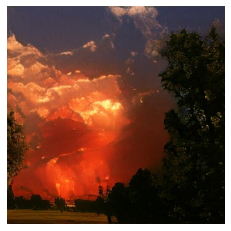

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Show and download results</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Показать и скачать результаты</font></b>

from google.colab import files, output

iter_num = 1 #@param {type:'integer'}
download_img = False #@param {type:'boolean'}
norm_num = (iter_num < len(os.listdir('/content/output')))
if norm_num:
  path_to_img = '/content/output/frame_' + str(iter_num).zfill(5) + '.jpg'
  image = cv2.imread(path_to_img)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.axis("off")
  plt.show()
else:
  print('You have not generated that many images.')
  print('Вы не сгенерировали так много картинок.')
if download_img and norm_num: files.download(path_to_img)